In [12]:
#Imports

import numpy as np
from matplotlib import pyplot as plt

In [4]:
#Run necessary code from existing notebooks.

#'disk.py' and 'blackhole.py' written. Rest won't work yet

%run scripts/bulge.py
%run scripts/disk.py
%run scripts/DMhalo.py
%run scripts/blackhole.py

In [13]:
#Set remaining necessary variables

#Will not work until necessary code is determined and set up.

r0 = np.linspace(0, 10, 20)
vtotal = lambda r: np.sqrt(vcdm(r)**2+vd**2+vbh(r)**2+vb**2)
vtotalv = np.vectorize(vtotal)

NameError: name 'vcdm' is not defined

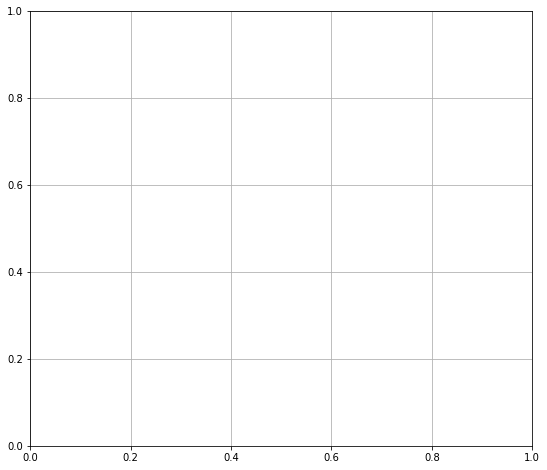

In [14]:
#Plot

#Will not work until necessary code is determined and set up.

fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(r0, vtotalv(r0), linestyle='solid', label='Velocity')          

plt.axis('tight');                                 #xmin, xmax, ymin, ymax
                                                   #or use: plt.xlim(10, 0) plt.ylim(1.2, -1.2);
                                                   #or to tighten the bounds: plt.axis('tight')
                                                   #or use: plt.axis([0, 15000, 0.5e6, 2.5e6])

fig.suptitle('Total Rotation Curve NGC5533', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,10)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
plt.savefig('total.png')